In [12]:
!pwd
!cd ~
!ls

/aiffel/aiffel/WorkPlace/Main_Quest_2
'사재원_Chest X-ray image classification.ipynb'


In [33]:
!unzip -q ~/aiffel/kaggle_xray/archive.zip -d ~/aiffel/kaggle_xray/

In [1]:
import os
print(os.listdir(os.getenv("HOME")+'/aiffel/kaggle_xray/chest_xray'))
dir_path=os.getenv("HOME")+'/aiffel/kaggle_xray/chest_xray/'

['chest_xray', 'test', '__MACOSX', 'train', 'val']


In [19]:
#category={'normal':0,'bacteria':1,"virus":2}# 0 NORMAL 1,2 PNEUMONIA

train_path=dir_path+'train/'
val_path=dir_path+'test/'

from keras.preprocessing.image import load_img
import numpy as np
def set_data(path):

    data,target=[],[]
    for category in os.listdir(path):
        count=0
        for img_path in os.listdir(path+category):
            img = load_img('{0}{1}/{2}'.format(path,category,img_path))
            img = img.resize((224,224))
            data.append(np.array(img))
            count+=1
            if category=='NORMAL':
                target.append(0)
            else:
                if img_path.split('_')[1]=='bacteria':
                    target.append(1)
                else:
                    target.append(2)
            if count==1500:#메모리 딸려서 일부만 진행
                break
    return data,target

train_data, train_target = set_data(train_path)
val_data, val_target = set_data(val_path)

In [20]:
train_data = np.array(train_data)
val_data = np.array(val_data)

print(train_data.shape)
print(val_data.shape)

(2841, 224, 224, 3)
(624, 224, 224, 3)


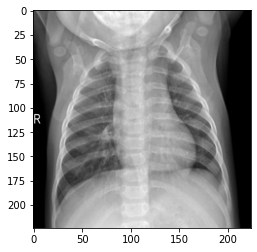

In [21]:
import matplotlib.pyplot as plt

plt.imshow(train_data[0])
plt.show()

In [22]:

num_classes = 3
train_target = np.eye(num_classes)[train_target]
val_target   = np.eye(num_classes)[val_target]

print(train_target.shape)
print(val_target.shape)

(2841, 3)
(624, 3)


In [3]:
#from keras.preprocessing.image import ImageDataGenerator
#
#data_augment = ImageDataGenerator(
#    rotation_range=10,  # 회전 각도 범위
#    width_shift_range=0.1,  # 가로 이동 범위
#    height_shift_range=0.1,  # 세로 이동 범위
#    horizontal_flip=True,  # 수평 반전
#)

In [ ]:
#train_data_gen = data_augment.flow(train_data,train_target, batch_size=len(train_data))

In [39]:
#print(train_data_gen[0][0].shape)
#for data,label in train_data_gen:

AttributeError: 'tuple' object has no attribute 'shape'

In [23]:
from tensorflow import keras
from keras.preprocessing import image

In [50]:
from tensorflow import keras
from tensorflow.keras import layers

data_aug_layers=keras.Sequential([layers.RandomFlip("horizontal"),
                                  layers.RandomRotation(0.1),
                                  layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1),fill_mode='nearest')
                                  ])
inputs = keras.Input(shape=(224,224,3))
x = data_aug_layers(inputs)
x = layers.Rescaling(1./255)(x)

def residual_block(input_tensor, filters, strides=1):
    shortcut = input_tensor

    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if strides != 1 or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='valid')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

input_shape = (224, 224, 3)  # 입력 이미지의 형태

inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

x = residual_block(x, filters=64)
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)

x = residual_block(x, filters=64, strides=2)
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)

x = residual_block(x, filters=128, strides=2)
x = residual_block(x, filters=128)
x = residual_block(x, filters=128)
x = residual_block(x, filters=128)
x = residual_block(x, filters=128)
x = residual_block(x, filters=128)

x = residual_block(x, filters=256, strides=2)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 112, 112, 64) 9472        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_145 (BatchN (None, 112, 112, 64) 256         conv2d_171[0][0]                 
__________________________________________________________________________________________________
activation_132 (Activation)     (None, 112, 112, 64) 0           batch_normalization_145[0][0]    
____________________________________________________________________________________________

In [46]:
#vgg 모델 
#절대 실행 하지마십쇼!!
##############################################
from tensorflow import keras
from tensorflow.keras import layers

data_aug_layers=keras.Sequential([layers.RandomFlip("horizontal"),
                                  layers.RandomRotation(0.1),
                                  layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1),fill_mode='nearest')
                                  ])
inputs = keras.Input(shape=(224,224,3))
x = data_aug_layers(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(64,7,activation='relu',padding="same")(x)
x = layers.Conv2D(64,3,activation='relu',padding="same")(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2,padding='same')(x)#56 56

x = layers.Conv2D(128,3,activation='relu',padding="same")(x)
x = layers.Conv2D(128,3,activation='relu',padding="same")(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2,padding='same')(x)#28 28

x = layers.Conv2D(256,3,activation='relu',padding="same")(x)
x = layers.Conv2D(256,3,activation='relu',padding="same")(x)
x = layers.Conv2D(256,3,activation='relu',padding="same")(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2,padding='same')(x)#14 #14

x = layers.Conv2D(512,3,activation='relu',padding="same")(x)
x = layers.Conv2D(512,3,activation='relu',padding="same")(x)
x = layers.Conv2D(512,3,activation='relu',padding="same")(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2,padding='same')(x)#7 7

x = layers.Conv2D(512,3,activation='relu',padding="same")(x)
x = layers.Conv2D(512,3,activation='relu',padding="same")(x)
x = layers.Conv2D(512,3,activation='relu',padding="same")(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2,padding='same')(x)#4 4

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024,activation='relu')(x)#7*7*512
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512,activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(3,activation='softmax')(x)

model=keras.Model(inputs,outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 224, 224, 64)      9472      
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 112, 112, 128)     7385

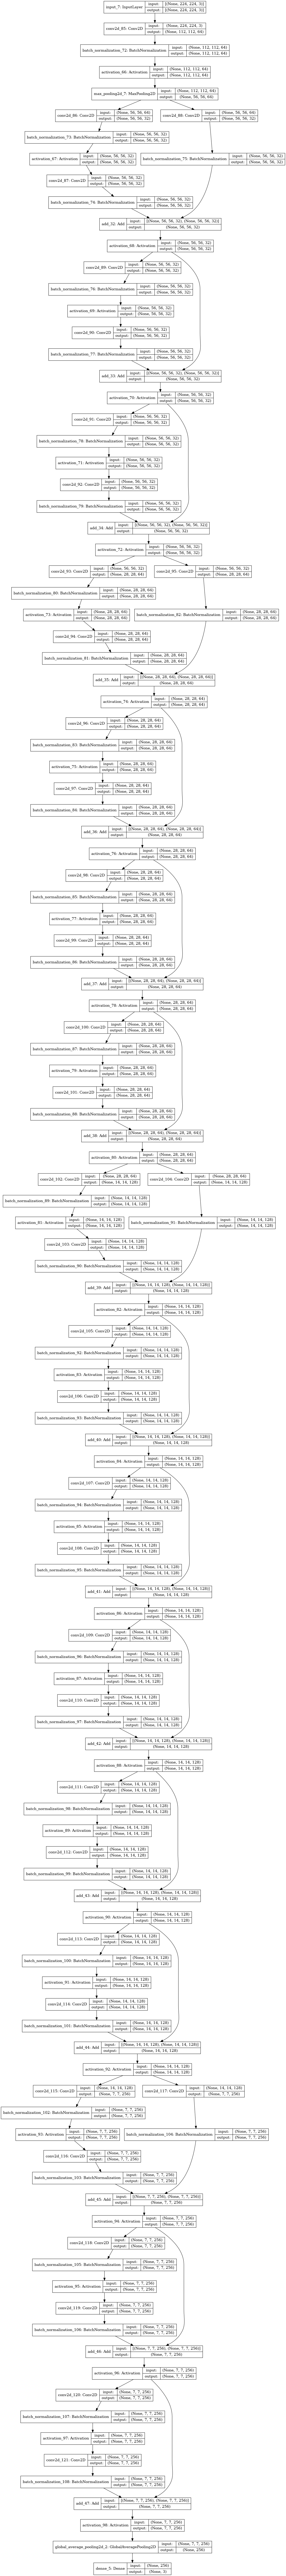

In [37]:
keras.utils.plot_model(model, "xray_classifier.png", show_shapes=True)

In [51]:
optim=keras.optimizers.Adam(lr=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=["accuracy"])
tensorboard=keras.callbacks.TensorBoard(log_dir="./log")

In [52]:
callbacks_list=[keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5),tensorboard]

In [53]:
history = model.fit(train_data,train_target,
         epochs=50,
         batch_size = 32,
         validation_data=(val_data,val_target),
         callbacks=callbacks_list,
         verbose=1,
         shuffle=True)

Epoch 1/50
89/89 [==============================] - 15s 134ms/step - loss: 0.8714 - accuracy: 0.6751 - val_loss: 18.6394 - val_accuracy: 0.3862
Epoch 2/50
89/89 [==============================] - 10s 116ms/step - loss: 0.5931 - accuracy: 0.7318 - val_loss: 174.4920 - val_accuracy: 0.3750
Epoch 3/50
89/89 [==============================] - 10s 116ms/step - loss: 0.5334 - accuracy: 0.7649 - val_loss: 10.1109 - val_accuracy: 0.3766
Epoch 4/50
89/89 [==============================] - 10s 115ms/step - loss: 0.4938 - accuracy: 0.7775 - val_loss: 34.6644 - val_accuracy: 0.3750
Epoch 5/50
89/89 [==============================] - 10s 114ms/step - loss: 0.4791 - accuracy: 0.7902 - val_loss: 1.9046 - val_accuracy: 0.5737
Epoch 6/50
89/89 [==============================] - 10s 113ms/step - loss: 0.4753 - accuracy: 0.7955 - val_loss: 3.7610 - val_accuracy: 0.4856
Epoch 7/50
89/89 [==============================] - 10s 114ms/step - loss: 0.4444 - accuracy: 0.8036 - val_loss: 10.7165 - val_accuracy: 

In [54]:
score = model.evaluate(val_data, val_target, verbose=1)

20/20 [==============================] - 1s 34ms/step - loss: 5.5633 - accuracy: 0.4215


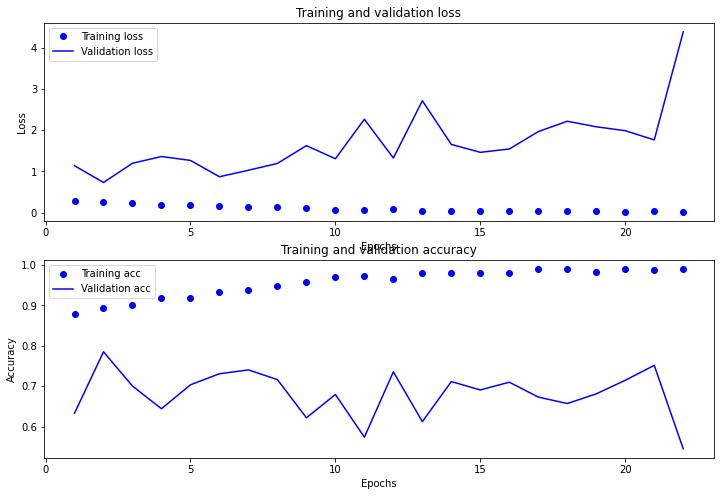

In [18]:
import matplotlib.pyplot as plt
history_dict = history.history 
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
    
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
    
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', elabel='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()